In [1]:
# coding: utf-8

# Initial deep neural network set-up from 
# Géron, A. 2017. Hands-On Machine Learning with Scikit-Learn 
#    & TensorFlow: Concepts, Tools, and Techniques to Build 
#    Intelligent Systems. Sebastopol, Calif.: O'Reilly. 
#    [ISBN-13 978-1-491-96229-9] 
#    Source code available at https://github.com/ageron/handson-ml
#    See file 10_introduction_to_artificial_neural_networks.ipynb 
#    Revised from MNIST to Cats and Dogs to begin Assignment 7
#    #CatsDogs# comment lines show additions/revisions for Cats and Dogs

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports for our work
import os 
import numpy as np
import tensorflow as tf
import time
RANDOM_SEED = 9999

# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [2]:
#CatsDogs# Old dimensions from MNIST no loger apply
#CatsDogs# height = 28
#CatsDogs# width = 28
height = 64
width = 64  

In [25]:
#CatsDogs# 
# Documentation on npy binary format for saving numpy arrays for later use
#     https://towardsdatascience.com/
#             why-you-should-start-using-npy-file-more-often-df2a13cc0161
# Under the working directory, data files are in directory cats_dogs_64_128 
# Read in cats and dogs grayscale 64x64 files to create training data
cats_1000_64_64_1 = np.load('cats-dogs-jump-start-v002/cats_dogs_64-128/cats_1000_64_64_1.npy')
dogs_1000_64_64_1 = np.load('cats-dogs-jump-start-v002/cats_dogs_64-128/dogs_1000_64_64_1.npy')

In [26]:
from matplotlib import pyplot as plt  # for display of images
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()


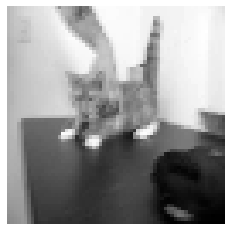

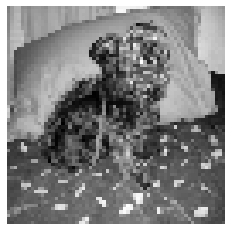

In [27]:
# Examine first cat and first dog grayscale images
show_grayscale_image(cats_1000_64_64_1[0,:,:,0])
show_grayscale_image(dogs_1000_64_64_1[0,:,:,0])

Rework the Data and Split into Train and Test Sets

In [34]:
# Work the data for cats and dogs numpy arrays 
# These numpy arrays were generated in previous data prep work
# Stack the numpy arrays for the inputs
X_cat_dog = np.concatenate((cats_1000_64_64_1, dogs_1000_64_64_1), axis = 0) 
X_cat_dog = X_cat_dog.reshape(-1,width*height) # note coversion to 4096 inputs

# Scikit Learn for min-max scaling of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(np.array([0., 255.]).reshape(-1,1))
X_cat_dog_min_max = scaler.transform(X_cat_dog)

# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(X_cat_dog_min_max, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [35]:
# 300 and 100 nodes for layers 1 and 2 as used with MNIST from Geron
n_hidden1 = 300
n_hidden2 = 100
channels = 1  # When working with color images use channels = 3
n_inputs = height * width

#CatsDogs# Has two output values # MNIST had ten digits n_outputs = 10  
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

DNN Framework

In [36]:
reset_graph()

# dnn... Deep neural network model from Geron Chapter 10
# Note that this model makes no use of the fact that we have
# pixel data arranged in rows and columns
# So a 64x64 matrix of raster values becomes a vector of 4096 input variables
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [37]:
init = tf.global_variables_initializer()    

n_epochs = 50
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_catdog_model")

0 Train accuracy: 0.64 Test accuracy: 0.5075
1 Train accuracy: 0.63 Test accuracy: 0.51
2 Train accuracy: 0.64 Test accuracy: 0.52
3 Train accuracy: 0.65 Test accuracy: 0.52
4 Train accuracy: 0.64 Test accuracy: 0.515
5 Train accuracy: 0.68 Test accuracy: 0.515
6 Train accuracy: 0.67 Test accuracy: 0.53
7 Train accuracy: 0.69 Test accuracy: 0.5275
8 Train accuracy: 0.69 Test accuracy: 0.535
9 Train accuracy: 0.69 Test accuracy: 0.5275
10 Train accuracy: 0.71 Test accuracy: 0.5275
11 Train accuracy: 0.73 Test accuracy: 0.54
12 Train accuracy: 0.68 Test accuracy: 0.525
13 Train accuracy: 0.68 Test accuracy: 0.515
14 Train accuracy: 0.72 Test accuracy: 0.5325
15 Train accuracy: 0.69 Test accuracy: 0.515
16 Train accuracy: 0.7 Test accuracy: 0.52
17 Train accuracy: 0.68 Test accuracy: 0.5125
18 Train accuracy: 0.78 Test accuracy: 0.55
19 Train accuracy: 0.79 Test accuracy: 0.56
20 Train accuracy: 0.82 Test accuracy: 0.59
21 Train accuracy: 0.81 Test accuracy: 0.54
22 Train accuracy: 0.68 T

In [21]:
reset_graph()

In [22]:
height = 64
width = 64 
channels = 1  # When working with color images use channels = 3
n_inputs = height * width
n_outputs = 2
conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"
#conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps
n_fc1 = 72
fc1_dropout_rate = 0.5

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 16 * 16])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")


with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = .001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
X_train, X_test, y_train, y_test = \
    train_test_split(X_cat_dog_min_max, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        


W0811 22:35:26.117274 20640 deprecation.py:323] From <ipython-input-22-2592acbce4da>:28: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0811 22:35:26.120302 20640 deprecation.py:506] From C:\Users\Himalaya\Anaconda3\envs\hello-tf\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0811 22:35:27.924288 20640 deprecation.py:323] From <ipython-input-22-2592acbce4da>:37: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


In [23]:
tf.shape(y)

<tf.Tensor 'Shape:0' shape=(1,) dtype=int32>

## Learning Rate .001
### Tested with 20, 25, and 30 epochs

In [24]:
init = tf.global_variables_initializer()    

n_epochs = 25
batch_size = 100
start = time.time()
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):

                
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
end = time.time()
Runtime = end-start
Runtime

0 Train accuracy: 0.59 Test accuracy: 0.48
1 Train accuracy: 0.6 Test accuracy: 0.495
2 Train accuracy: 0.67 Test accuracy: 0.53
3 Train accuracy: 0.66 Test accuracy: 0.5975
4 Train accuracy: 0.72 Test accuracy: 0.59
5 Train accuracy: 0.76 Test accuracy: 0.6125
6 Train accuracy: 0.73 Test accuracy: 0.6125
7 Train accuracy: 0.8 Test accuracy: 0.6275
8 Train accuracy: 0.86 Test accuracy: 0.6275
9 Train accuracy: 0.92 Test accuracy: 0.625
10 Train accuracy: 0.92 Test accuracy: 0.635
11 Train accuracy: 0.94 Test accuracy: 0.6225
12 Train accuracy: 0.98 Test accuracy: 0.6425
13 Train accuracy: 1.0 Test accuracy: 0.63
14 Train accuracy: 1.0 Test accuracy: 0.635
15 Train accuracy: 0.9 Test accuracy: 0.6325
16 Train accuracy: 0.99 Test accuracy: 0.62
17 Train accuracy: 1.0 Test accuracy: 0.6375
18 Train accuracy: 0.99 Test accuracy: 0.6075
19 Train accuracy: 1.0 Test accuracy: 0.6325
20 Train accuracy: 1.0 Test accuracy: 0.62
21 Train accuracy: 1.0 Test accuracy: 0.6225
22 Train accuracy: 1.0 

118.01953792572021

In [25]:
reset_graph()

In [26]:
height = 64
width = 64 
channels = 1  # When working with color images use channels = 3
n_inputs = height * width
n_outputs = 2
conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"
#conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps
n_fc1 = 72
fc1_dropout_rate = 0.5

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 16 * 16])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")


with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = .1)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
X_train, X_test, y_train, y_test = \
    train_test_split(X_cat_dog_min_max, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        

## Learning Rate .1

In [27]:
init = tf.global_variables_initializer()    

n_epochs = 20
batch_size = 100
start = time.time()
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):                
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
end = time.time()
Runtime = end-start
Runtime

0 Train accuracy: 0.59 Test accuracy: 0.48
1 Train accuracy: 0.59 Test accuracy: 0.48
2 Train accuracy: 0.41 Test accuracy: 0.52
3 Train accuracy: 0.59 Test accuracy: 0.48
4 Train accuracy: 0.59 Test accuracy: 0.48
5 Train accuracy: 0.59 Test accuracy: 0.48
6 Train accuracy: 0.59 Test accuracy: 0.48
7 Train accuracy: 0.59 Test accuracy: 0.48
8 Train accuracy: 0.59 Test accuracy: 0.48
9 Train accuracy: 0.59 Test accuracy: 0.48
10 Train accuracy: 0.59 Test accuracy: 0.48
11 Train accuracy: 0.59 Test accuracy: 0.48
12 Train accuracy: 0.59 Test accuracy: 0.48
13 Train accuracy: 0.59 Test accuracy: 0.48
14 Train accuracy: 0.59 Test accuracy: 0.48
15 Train accuracy: 0.59 Test accuracy: 0.48
16 Train accuracy: 0.59 Test accuracy: 0.48
17 Train accuracy: 0.59 Test accuracy: 0.48
18 Train accuracy: 0.59 Test accuracy: 0.48
19 Train accuracy: 0.59 Test accuracy: 0.48


261.69815611839294

 With .1 Learning Rate there is is no improvement in learning

In [31]:
reset_graph()

In [32]:
height = 64
width = 64 
channels = 1  # When working with color images use channels = 3
n_inputs = height * width
n_outputs = 2
conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"
#conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps
n_fc1 = 72
fc1_dropout_rate = 0.5

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 16 * 16])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")


with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = .0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
X_train, X_test, y_train, y_test = \
    train_test_split(X_cat_dog_min_max, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)

## Learning Rate .0001
### Tested with 20, 25, and 30 epochs
### Also tested batch sizes 50, 100 and 200, with no increase in performance 

In [35]:
init = tf.global_variables_initializer()    

n_epochs = 30
batch_size = 50
iteration = 0

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

start = time.time()
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

end = time.time()
Runtime = end-start
Runtime

0 Train accuracy: 0.64 Test accuracy: 0.505
1 Train accuracy: 0.66 Test accuracy: 0.5425
2 Train accuracy: 0.7 Test accuracy: 0.585
3 Train accuracy: 0.72 Test accuracy: 0.59
4 Train accuracy: 0.74 Test accuracy: 0.5925
5 Train accuracy: 0.76 Test accuracy: 0.6125
6 Train accuracy: 0.76 Test accuracy: 0.6325
7 Train accuracy: 0.82 Test accuracy: 0.63
8 Train accuracy: 0.86 Test accuracy: 0.625
9 Train accuracy: 0.88 Test accuracy: 0.6225
10 Train accuracy: 0.88 Test accuracy: 0.63
11 Train accuracy: 0.92 Test accuracy: 0.6375
12 Train accuracy: 0.94 Test accuracy: 0.635
13 Train accuracy: 0.94 Test accuracy: 0.6325
14 Train accuracy: 0.92 Test accuracy: 0.6325
15 Train accuracy: 0.92 Test accuracy: 0.63
16 Train accuracy: 0.92 Test accuracy: 0.6325
17 Train accuracy: 0.94 Test accuracy: 0.6275
18 Train accuracy: 0.94 Test accuracy: 0.635
19 Train accuracy: 0.94 Test accuracy: 0.64
20 Train accuracy: 0.94 Test accuracy: 0.6425
21 Train accuracy: 0.96 Test accuracy: 0.6425
22 Train accur

393.7229838371277

In [ ]:
reset_graph()